# WeatherPy
The following is a Python script to help visualize the weather patterns of 500+ randomly selected cities across the world of varying distance from the equator. The data collected allows us to observe the following trends:
- The cities near the ecuator (with latitude = 0) show higher temperatures within a range of 60F to approx 100F. There is a strong negative correlation between the temperature and latitide. In other words, the more north a city is the lower the temperature reported. 
- The wind speed average around 8 to 10 mph across all sample cities. But otherwise show a weak correlation with respect to the latitude.
- The % cloudiness does not show to have any correlation with latitude. It averages around 40% but with a large variance of apprx 35. 
- The humidty % collected for this sample average is between 75% and 80%, with a large variance of 21 showing a weak correlation with latitude.

In [1]:
# Dependencies
import requests as req
import time
from citipy import citipy
from random import randrange
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
#update config with api key 
from config import OpenWeather


In [2]:
# create filenames for the output files
output_csv = "figures/WeatherPy.csv"
output_temp = "figures/WeatherPyTemperature.png"
output_cloud = "figures/WeatherPyCloudiness.png"
output_windsp = "figures/WeatherPyWindspeed.png"
output_humid ="figures/WeatherPyHumidity.png"
output_log = "log/WeatherPylogrequests.txt"
output_err = "log/WeatherPylogerrors.txt"

In [3]:
# Input will be froom a selection of 500+ random coordinates. We want to generate a list a 500+ unique cities. 
num_coordinates = 1500
coordinates = [(randrange(-90,90), randrange(-180,180)) 
               for c in range(0,num_coordinates)]
cities = set()
for lat, lon in coordinates:
    cities.add(citipy.nearest_city(lat, lon).city_name)

print(f"From {len(coordinates)} random coordinates we generated a list of {len(cities)} different cities")

From 1500 random coordinates we generated a list of 632 different cities


In [4]:
# Setup endpoint information.
url = "http://api.openweathermap.org/data/2.5/weather"

In [5]:
# Set query parameters
params = {'appid': OpenWeather,
          'q': '',
          'units': 'imperial'}

In [6]:
# Loop through the list of cities and perform a request for data on each
weather_data = []
request_errors =[]
waiting = "|/-\\"
widx = 0

with open(output_log, 'w', newline='') as logfile:
    logfile.write("LOGFILE for City Weather Requests")
    for city in cities:
        # Get weather data
        params['q'] = city
        try:
            response = req.get(url, params=params)
            response.raise_for_status()
            weather_json = response.json()
            weather_data.append({'name':weather_json['name'],
                                 'temperature':weather_json["main"]["temp"],
                                'humidity':weather_json["main"]["humidity"],
                      'windspeed':weather_json["wind"]["speed"],
                      'cloudiness':weather_json["clouds"]["all"],
                      'latitude':weather_json["coord"]["lat"],
                      'longitude':weather_json['coord']['lon']})
            # log request
            logfile.write("\nCity: "+city +
                          "\nRequest: "+ str(response.url)+
                          "\nResponse " + str(response.status_code))
            
            # show some progress and allow for time between server requests
            print("Waiting "+ waiting[widx % len(waiting)] + "\r",end='')
            widx += 1
            time.sleep(.25)
        except req.exceptions.RequestException as e:
            request_errors.append("City: "+ city + " error " + str(e)+'\n')
            logfile.write("\nCity: "+city +
                          "\nRequest: "+ str(response.url)+
                          "\nResponse " + str(response.status_code) +
                         "\nError: "+str(e))
            
fails = len(request_errors)
total = len(cities)
success = total - fails
print("\r Completed")
print(f"{success} Successful requests from Open Weather. From a total of {len(cities)} attempts of random coordinates.")  
print(f"See request log in {output_log}")
print("--------------------------------")
if len(request_errors)>0:
    with open(output_err,'w', newline='\n') as errfile:
        print(f"See error log in {output_err}")
        errfile.write(f"{len(request_errors)} failed requests:\n")
        errfile.writelines(request_errors)
        #for err in request_errors:
        #    errfile.write(err)

 Completed
558 Successful requests from Open Weather. From a total of 632 attempts of random coordinates.
See request log in log/WeatherPylogrequests.txt
--------------------------------
See error log in log/WeatherPylogerrors.txt


In [7]:
# Create Data Frame with weather data        
city_weather_df = pd.DataFrame(weather_data)
city_weather_df.head()

,cloudiness,humidity,latitude,longitude,name,temperature,windspeed
0,75,62,37.46,-122.43,Half Moon Bay,54.14,11.41
1,92,92,37.02,111.92,Jiexiu,31.64,2.71
2,75,69,-17.53,-149.33,Tiarei,80.60,11.41
3,0,96,16.32,121.70,Dumabato,71.01,3.71
4,0,68,-37.88,147.99,Lakes Entrance,74.34,5.28


In [8]:
# Save data in a csv file
city_weather_df.to_csv(output_csv)

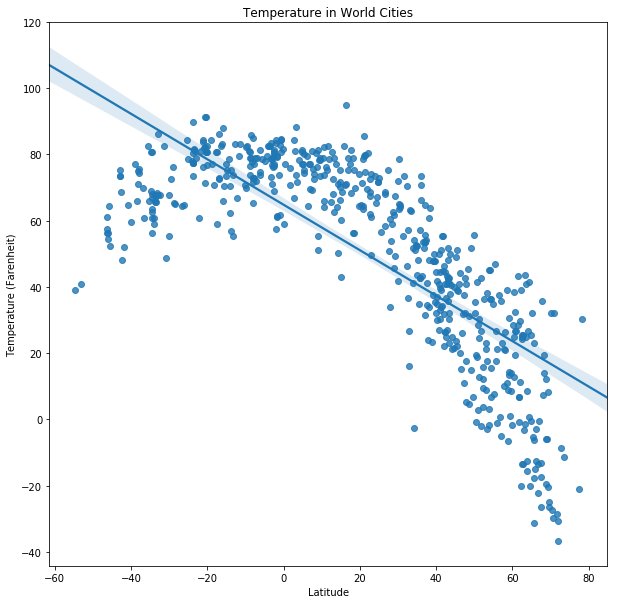

In [9]:
# plot the relationship Temperature (F) vs. Latitude
fig = plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111)
# Build a scatter plot for each data type
sns.regplot(x="latitude", y="temperature", data=city_weather_df)

# Incorporate the other graph properties
plt.title("Temperature in World Cities")
plt.ylabel("Temperature (Farenheit)")
plt.xlabel("Latitude")

# Save the figure
plt.savefig(output_temp)
plt.legend(loc='best')
plt.show()

Avg = 76.1236559139785, Variance = 21.277278098266688


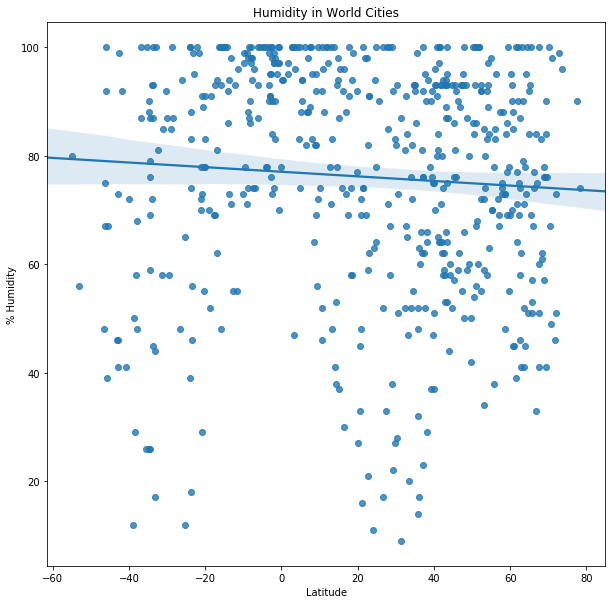

In [10]:
# plot the relationship Humidity (%) vs. Latitude
fig = plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111)

avg = city_weather_df['humidity'].mean()
variance = city_weather_df['humidity'].std()
print(f"Avg = {avg}, Variance = {variance}")
# Build a scatter plot for each data type
sns.regplot(x="latitude", y="humidity", data = city_weather_df)

# Incorporate the other graph properties
plt.title("Humidity in World Cities")
plt.ylabel("% Humidity")
plt.xlabel("Latitude")

# Save the figure
plt.savefig(output_humid)
plt.legend(loc='best')
plt.show()

Avg = 39.74372759856631, Variance = 35.02316117592912


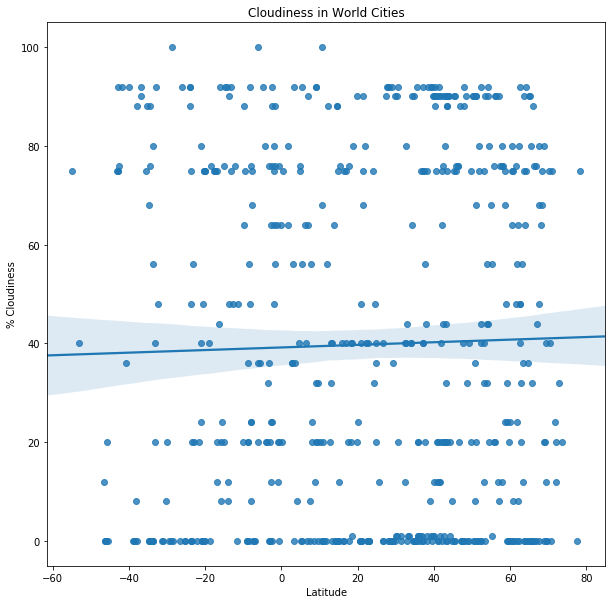

In [11]:
# plot the relationship Cloudiness (%) vs. Latitude
fig = plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111)

avg = city_weather_df['cloudiness'].mean()
variance = city_weather_df['cloudiness'].std()
print(f"Avg = {avg}, Variance = {variance}")
# Build a scatter plot for each data type
sns.regplot(x="latitude", y="cloudiness", data = city_weather_df)

# Incorporate the other graph properties
plt.title("Cloudiness in World Cities")
plt.ylabel("% Cloudiness")
plt.xlabel("Latitude")

# Save the figure
plt.savefig(output_cloud)
plt.legend(loc='best')
plt.show()

Avg = 8.098458781362014, Variance = 5.699604520998323


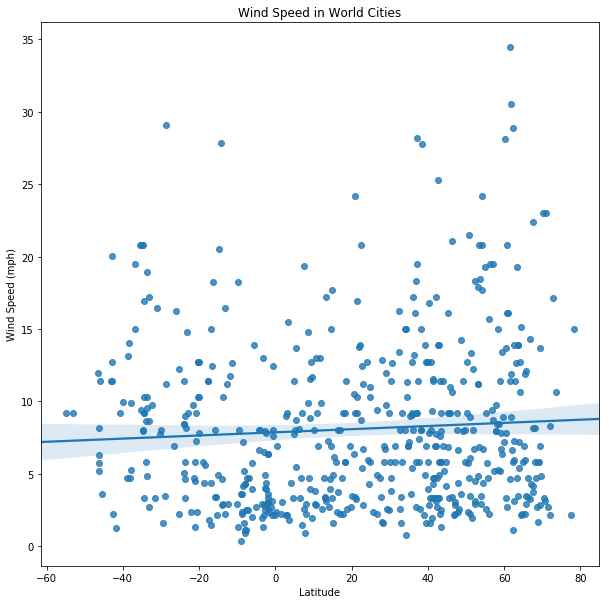

In [12]:
# plot the relationship Wind Speed (mph) vs. Latitude
fig = plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111)

avg = city_weather_df['windspeed'].mean()
variance = city_weather_df['windspeed'].std()
print(f"Avg = {avg}, Variance = {variance}")
# Build a scatter plot for each data type
sns.regplot(x="latitude", y="windspeed", data = city_weather_df)

# Incorporate the other graph properties
plt.title("Wind Speed in World Cities")
plt.ylabel("Wind Speed (mph)")
plt.xlabel("Latitude")

# Save the figure
plt.savefig(output_windsp)
plt.legend(loc='best')
plt.show()